### BIB

In [1]:
import os
import numpy as np
import time
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
import segmentation_models as sm
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from sklearn.model_selection import train_test_split

Segmentation Models: using `keras` framework.


### CARREGAR IMAGENS

In [2]:
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import os
import time

def load_data(images_path, masks_path, target_size=(256, 256), mask_normalization=True, shuffle=True, grayscale=False):
    """
    Carrega imagens e máscaras de diretórios, redimensionando-as, opcionalmente convertendo para tons de cinza
    e embaralhando.

    Args:
        images_path (str): Caminho para as imagens.
        masks_path (str): Caminho para as máscaras.
        target_size (tuple): Dimensão para redimensionar as imagens e máscaras.
        mask_normalization (bool): Se True, normaliza as máscaras para valores binários.
        shuffle (bool): Se True, embaralha as imagens e máscaras mantendo os pares.
        grayscale (bool): Se True, converte as imagens para tons de cinza.

    Returns:
        tuple: Arrays de imagens e máscaras (possivelmente embaralhados e convertidos).
    """
    images = []
    masks = []

    print(f"Carregando imagens de: {images_path}")
    start_time = time.time()

    for i, img_file in enumerate(sorted(os.listdir(images_path))):
        if img_file.endswith(('.png', '.jpg', '.jpeg')):
            # Carregar e redimensionar imagens
            img = load_img(os.path.join(images_path, img_file), target_size=target_size)
            img = img_to_array(img) / 255.0  # Normaliza para [0, 1]
            # Converter para tons de cinza, se solicitado
            if grayscale:
                img = np.mean(img, axis=-1, keepdims=True)  # Média ao longo dos canais RGB
            images.append(img)
            if (i + 1) % 10 == 0:
                print(f"{i + 1} imagens carregadas...")

    print(f"Carregamento de imagens concluído em {time.time() - start_time:.2f} segundos.")
    print(f"Carregando máscaras de: {masks_path}")

    start_time = time.time()

    for i, mask_file in enumerate(sorted(os.listdir(masks_path))):
        if mask_file.endswith(('.png', '.jpg', '.jpeg')):
            # Carregar e redimensionar máscaras
            mask = load_img(os.path.join(masks_path, mask_file), color_mode='grayscale', target_size=target_size)
            mask = img_to_array(mask)
            if mask_normalization:
                mask = (mask > 0).astype(np.float32)  # Binário
            masks.append(mask)
            if (i + 1) % 10 == 0:
                print(f"{i + 1} máscaras carregadas...")

    print(f"Carregamento de máscaras concluído em {time.time() - start_time:.2f} segundos.")

    # Convertendo para arrays
    images = np.array(images)
    masks = np.array(masks)

    # Embaralhar se solicitado
    if shuffle:
        print("Embaralhando o conjunto de dados...")
        indices = np.random.permutation(len(images))
        images = images[indices]
        masks = masks[indices]

    return images, masks

# Carregar dados com embaralhamento e conversão para tons de cinza
print("Carregando dados de treinamento...")
train_images, train_masks = load_data('treino/images_pad', 'treino/mask_pad', shuffle=True, grayscale=False)
print("Carregando dados de validação...")
val_images, val_masks = load_data('val/images_pad', 'val/mask_pad', shuffle=True, grayscale=False)
print("Carregando dados de teste (sem embaralhamento)...")
test_images, test_masks = load_data('teste/images_pad', 'teste/mask_pad', shuffle=False, grayscale=False)

print("Carregamento completo!")


Carregando dados de treinamento...
Carregando imagens de: treino/images_pad
10 imagens carregadas...
20 imagens carregadas...
30 imagens carregadas...
40 imagens carregadas...
50 imagens carregadas...
60 imagens carregadas...
70 imagens carregadas...
80 imagens carregadas...
90 imagens carregadas...
100 imagens carregadas...
110 imagens carregadas...
120 imagens carregadas...
130 imagens carregadas...
140 imagens carregadas...
150 imagens carregadas...
160 imagens carregadas...
170 imagens carregadas...
180 imagens carregadas...
190 imagens carregadas...
200 imagens carregadas...
210 imagens carregadas...
220 imagens carregadas...
230 imagens carregadas...
240 imagens carregadas...
250 imagens carregadas...
260 imagens carregadas...
270 imagens carregadas...
280 imagens carregadas...
290 imagens carregadas...
300 imagens carregadas...
310 imagens carregadas...
320 imagens carregadas...
330 imagens carregadas...
340 imagens carregadas...
350 imagens carregadas...
360 imagens carregadas.

In [3]:
print(f"Treino: {train_images.shape}, {train_masks.shape}")
print(f"Validação: {val_images.shape}, {val_masks.shape}")
print(f"Teste: {test_images.shape}, {test_masks.shape}")

Treino: (3961, 256, 256, 3), (3961, 256, 256, 1)
Validação: (581, 256, 256, 3), (581, 256, 256, 1)
Teste: (542, 256, 256, 3), (542, 256, 256, 1)


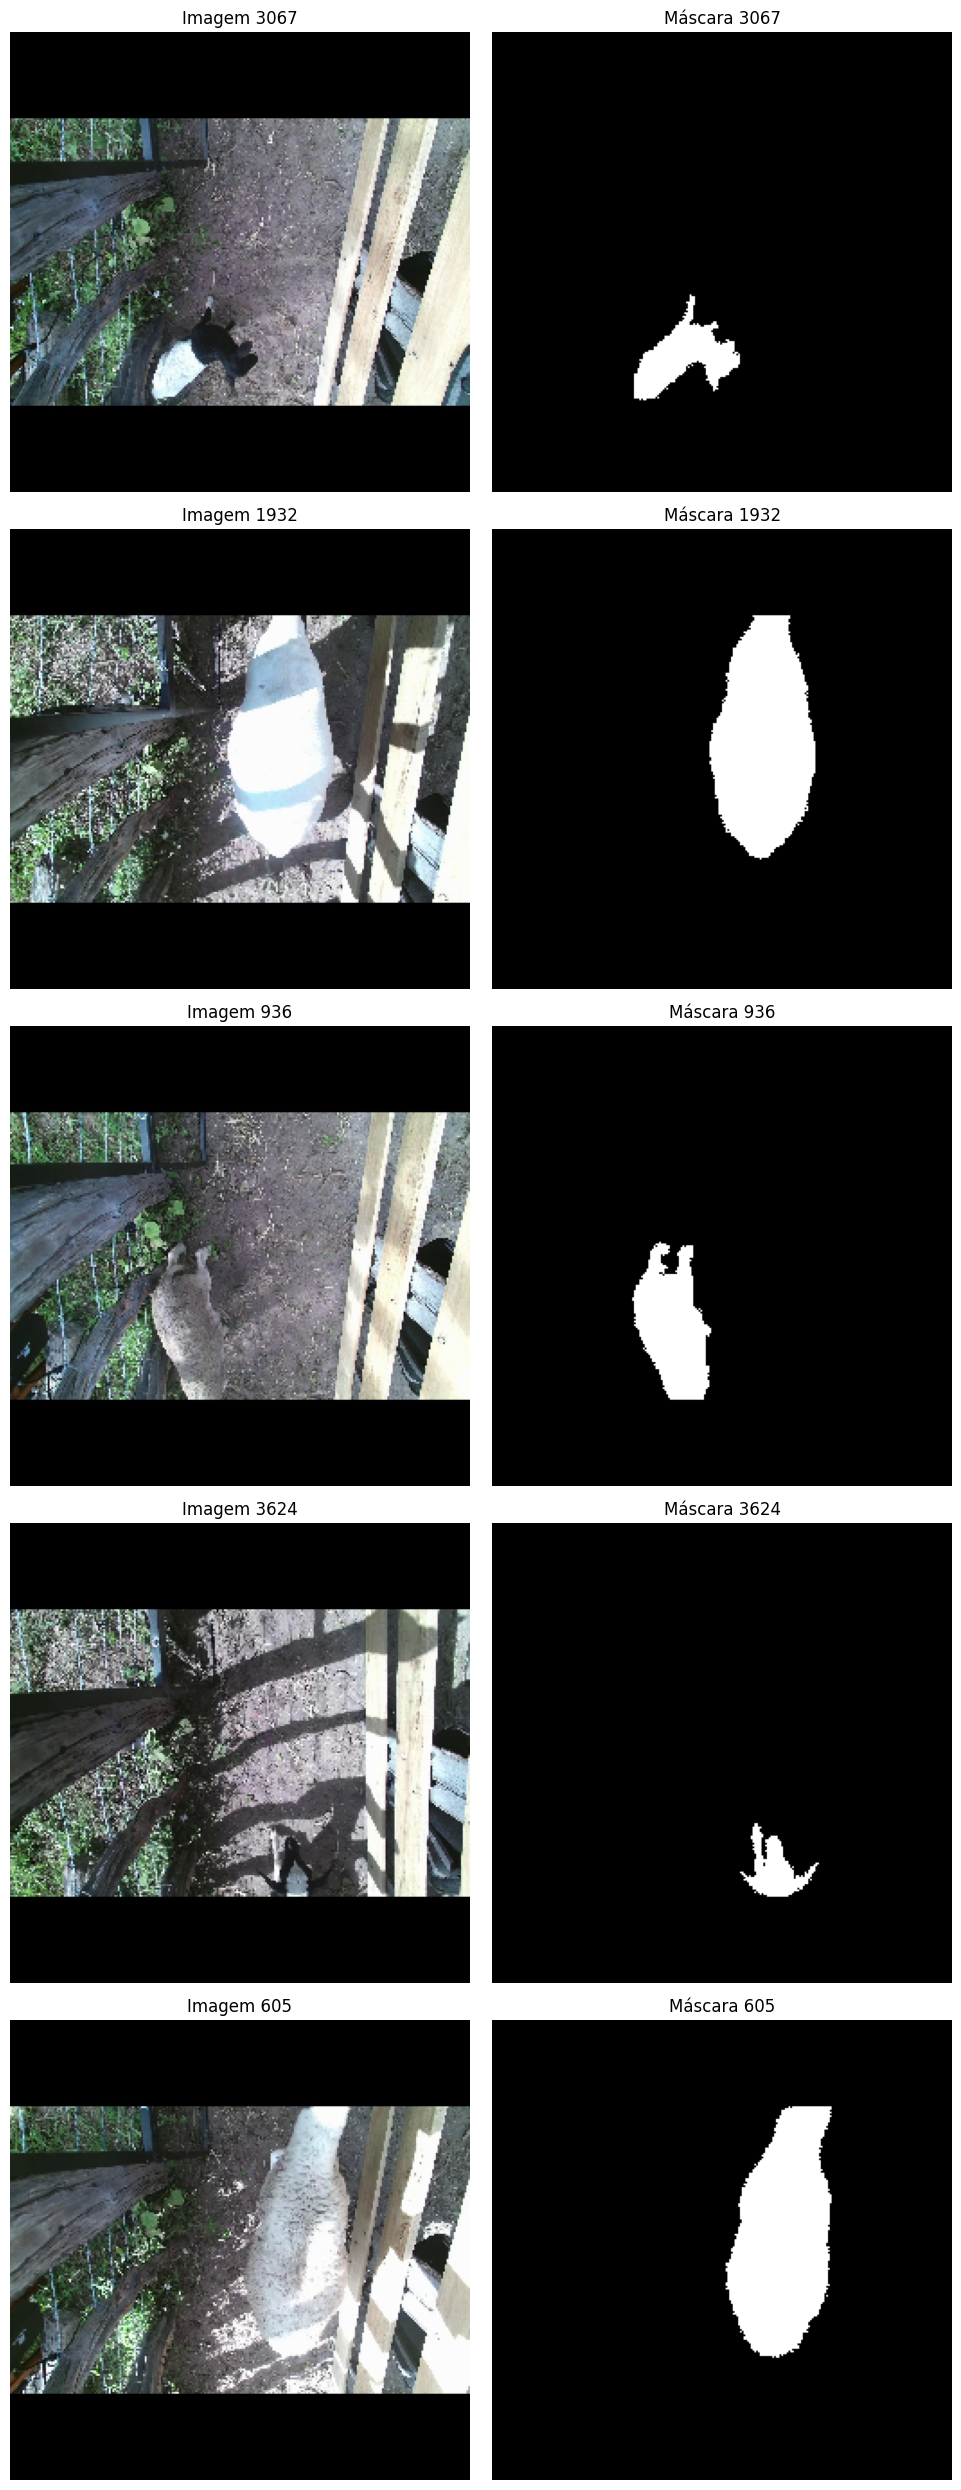

In [4]:
import matplotlib.pyplot as plt
import random

def plot_random_samples(images, masks, num_samples=5):
    """
    Seleciona aleatoriamente algumas amostras de imagens e máscaras e as exibe.

    Args:
        images (np.array): Array de imagens.
        masks (np.array): Array de máscaras correspondentes.
        num_samples (int): Número de amostras a serem exibidas.
    """
    # Selecionar índices aleatórios
    indices = random.sample(range(len(images)), num_samples)

    # Criar subplots
    fig, axes = plt.subplots(num_samples, 2, figsize=(10, 5 * num_samples))

    for i, idx in enumerate(indices):
        # Imagem
        axes[i, 0].imshow(images[idx])
        axes[i, 0].set_title(f"Imagem {idx}")
        axes[i, 0].axis('off')

        # Máscara
        axes[i, 1].imshow(masks[idx].squeeze(), cmap='gray')
        axes[i, 1].set_title(f"Máscara {idx}")
        axes[i, 1].axis('off')

    plt.tight_layout()
    plt.show()

# Selecionar e visualizar 5 amostras do conjunto de treinamento
plot_random_samples(train_images, train_masks, num_samples=5)

### UNET 

In [5]:
# Configurar a U-Net pré-treinada
BACKBONE = 'densenet169'
sm.set_framework('tf.keras')
sm.framework()

'tf.keras'

In [6]:
# Modelo U-Net
model = sm.Unet(
    backbone_name=BACKBONE,
    encoder_weights='imagenet',  # Pesos pré-treinados
    input_shape=(256, 256, 3),
    classes=1,  # Binário
    activation='sigmoid'
)

In [7]:
from tensorflow.keras.optimizers import Adam
import segmentation_models as sm  # Certifique-se de ter o segmentation_models instalado

# Função de perda Dice Loss
def dice_loss(y_true, y_pred, smooth=1e-6):
    """
    Função de perda Dice Loss.
    
    Args:
        y_true (tensor): Máscaras verdadeiras.
        y_pred (tensor): Máscaras preditas pelo modelo.
        smooth (float): Valor para evitar divisão por zero.
    
    Returns:
        tensor: Valor da perda Dice.
    """
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)

# Compilar o modelo
model.compile(
    optimizer=Adam(learning_rate=0.0003),  # Define a taxa de aprendizado
    loss=dice_loss,  # Define Dice Loss como função de perda
    metrics=[
        sm.metrics.IOUScore(),  # Métrica IoU (Jaccard Index)
        sm.metrics.FScore()  # Métrica F-Score
    ]
)

print("Modelo recompilado com Dice Loss e learning rate de 0.00003.")


Modelo recompilado com Dice Loss e learning rate de 0.00003.


In [8]:
# Configurar callbacks
callbacks = [
    ModelCheckpoint(
        filepath='best_model_pre.h5',  # Nome do arquivo para salvar o melhor modelo
        monitor='val_loss',        # Monitora a perda em validação
        save_best_only=True,       # Salva apenas se for o melhor modelo
        mode='min',                # Busca minimizar a perda
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',        # Monitora a perda em validação
        factor=0.5,                # Reduz a taxa de aprendizado pela metade
        patience=5,                # Número de epochs sem melhora para reduzir o LR
        min_lr=0.00003,               # Taxa de aprendizado mínima
        verbose=1
    ),
    EarlyStopping(
        monitor='val_loss',        # Monitora a perda em validação
        patience=15,               # Número de epochs sem melhora para parar
        mode='min',                # Busca minimizar a perda
        verbose=1,
        restore_best_weights=True  # Restaura os pesos do melhor modelo
    )
]

In [9]:
# Treinamento
EPOCHS = 100
BATCH_SIZE = 8

In [10]:
history = model.fit(
    x=train_images,
    y=train_masks,
    validation_data=(val_images, val_masks),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=callbacks
)

Epoch 1/100
496/496 [==============================] - ETA: 0s - loss: 0.2709 - iou_score: 0.6296 - f1-score: 0.7294
Epoch 1: val_loss improved from inf to 0.11399, saving model to best_model_pre.h5
496/496 [==============================] - 119s 178ms/step - loss: 0.2709 - iou_score: 0.6296 - f1-score: 0.7294 - val_loss: 0.1140 - val_iou_score: 0.7963 - val_f1-score: 0.8861 - lr: 3.0000e-04
Epoch 2/100
496/496 [==============================] - ETA: 0s - loss: 0.0435 - iou_score: 0.9170 - f1-score: 0.9565
Epoch 2: val_loss improved from 0.11399 to 0.04952, saving model to best_model_pre.h5
496/496 [==============================] - 75s 151ms/step - loss: 0.0435 - iou_score: 0.9170 - f1-score: 0.9565 - val_loss: 0.0495 - val_iou_score: 0.9059 - val_f1-score: 0.9505 - lr: 3.0000e-04
Epoch 3/100
496/496 [==============================] - ETA: 0s - loss: 0.0312 - iou_score: 0.9396 - f1-score: 0.9688
Epoch 3: val_loss improved from 0.04952 to 0.04094, saving model to best_model_pre.h5
496/

### TESTE

In [11]:
# Avaliação no conjunto de teste
results = model.evaluate(test_images, test_masks)
print(f"Avaliação no conjunto de teste: {results}")

17/17 [==============================] - 7s 286ms/step - loss: 0.0333 - iou_score: 0.9357 - f1-score: 0.9667
Avaliação no conjunto de teste: [0.03329871594905853, 0.9356845617294312, 0.9667114019393921]


In [12]:
model.load_weights('best_model_pre.h5')

In [13]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Inicializar listas para armazenar métricas
dice_scores = []
jaccard_scores = []
sensitivities = []
specificities = []
accuracies = []
precisions = []
fscores = []

# Iterar sobre cada imagem e calcular métricas
for i in range(len(test_images)):
    # Predição para a imagem individual
    y_pred = model.predict(np.expand_dims(test_images[i], axis=0), batch_size=1)
    
    # Binarizar predição e máscara verdadeira
    y_true = (test_masks[i] > 0.5).astype(np.int32).flatten()
    y_pred_bin = (y_pred.squeeze() > 0.5).astype(np.int32).flatten()

    # Matriz de confusão
    cm = confusion_matrix(y_true, y_pred_bin, labels=[0, 1]).ravel()
    if len(cm) == 4:  # Certificar-se de que todos os valores estão presentes
        tn, fp, fn, tp = cm
    else:  # Caso raro em que faltam categorias
        tn, fp, fn, tp = [0, 0, 0, 0]
    
    # Cálculo das métricas
    dice = (2.0 * tp) / ((2.0 * tp) + fp + fn) if (tp + fp + fn) > 0 else 0
    jaccard = (1.0 * tp) / (tp + fp + fn) if (tp + fp + fn) > 0 else 0
    sensitivity = (1.0 * tp) / (tp + fn) if (tp + fn) > 0 else 0
    specificity = (1.0 * tn) / (tn + fp) if (tn + fp) > 0 else 0
    accuracy = (1.0 * (tn + tp)) / (tn + fp + tp + fn) if (tn + fp + tp + fn) > 0 else 0
    precision = float(tp) / float(tp + fp) if (tp + fp) > 0 else 0
    fscore = float(2 * tp) / float(2 * tp + fp + fn) if (2 * tp + fp + fn) > 0 else 0

    # Armazenar métricas
    dice_scores.append(dice)
    jaccard_scores.append(jaccard)
    sensitivities.append(sensitivity)
    specificities.append(specificity)
    accuracies.append(accuracy)
    precisions.append(precision)
    fscores.append(fscore)

    # Print das métricas para a imagem atual
    print(f"Imagem {i+1}/{len(test_images)}:")
    print(f"  Dice: {dice:.2f}")
    print(f"  Jaccard: {jaccard:.2f}")
    print(f"  Sensitivity (Recall): {sensitivity:.2f}")
    print(f"  Specificity: {specificity:.2f}")
    print(f"  Accuracy: {accuracy:.2f}")
    print(f"  Precision: {precision:.2f}")
    print(f"  F-Score: {fscore:.2f}")
    print('-' * 55)

# Calcular as médias de todas as métricas
mean_dice = np.mean(dice_scores)
mean_jaccard = np.mean(jaccard_scores)
mean_sensitivity = np.mean(sensitivities)
mean_specificity = np.mean(specificities)
mean_accuracy = np.mean(accuracies)
mean_precision = np.mean(precisions)
mean_fscore = np.mean(fscores)

# Print das médias
print("\nMétricas Médias no Conjunto de Teste:")
print(f"  Mean Dice: {mean_dice:.2f}")
print(f"  Mean Jaccard: {mean_jaccard:.2f}")
print(f"  Mean Sensitivity (Recall): {mean_sensitivity:.2f}")
print(f"  Mean Specificity: {mean_specificity:.2f}")
print(f"  Mean Accuracy: {mean_accuracy:.2f}")
print(f"  Mean Precision: {mean_precision:.2f}")
print(f"  Mean F-Score: {mean_fscore:.2f}")
print('-' * 55)

1/1 [==============================] - 3s 3s/step
Imagem 1/542:
  Dice: 0.62
  Jaccard: 0.45
  Sensitivity (Recall): 0.49
  Specificity: 1.00
  Accuracy: 1.00
  Precision: 0.87
  F-Score: 0.62
-------------------------------------------------------
1/1 [==============================] - 0s 41ms/step
Imagem 2/542:
  Dice: 0.93
  Jaccard: 0.86
  Sensitivity (Recall): 0.90
  Specificity: 1.00
  Accuracy: 1.00
  Precision: 0.95
  F-Score: 0.93
-------------------------------------------------------
1/1 [==============================] - 0s 42ms/step
Imagem 3/542:
  Dice: 0.91
  Jaccard: 0.83
  Sensitivity (Recall): 0.86
  Specificity: 1.00
  Accuracy: 1.00
  Precision: 0.96
  F-Score: 0.91
-------------------------------------------------------
1/1 [==============================] - 0s 45ms/step
Imagem 4/542:
  Dice: 0.93
  Jaccard: 0.87
  Sensitivity (Recall): 0.92
  Specificity: 1.00
  Accuracy: 1.00
  Precision: 0.94
  F-Score: 0.93
------------------------------------------------------

91/91 [==============================] - 10s 58ms/step


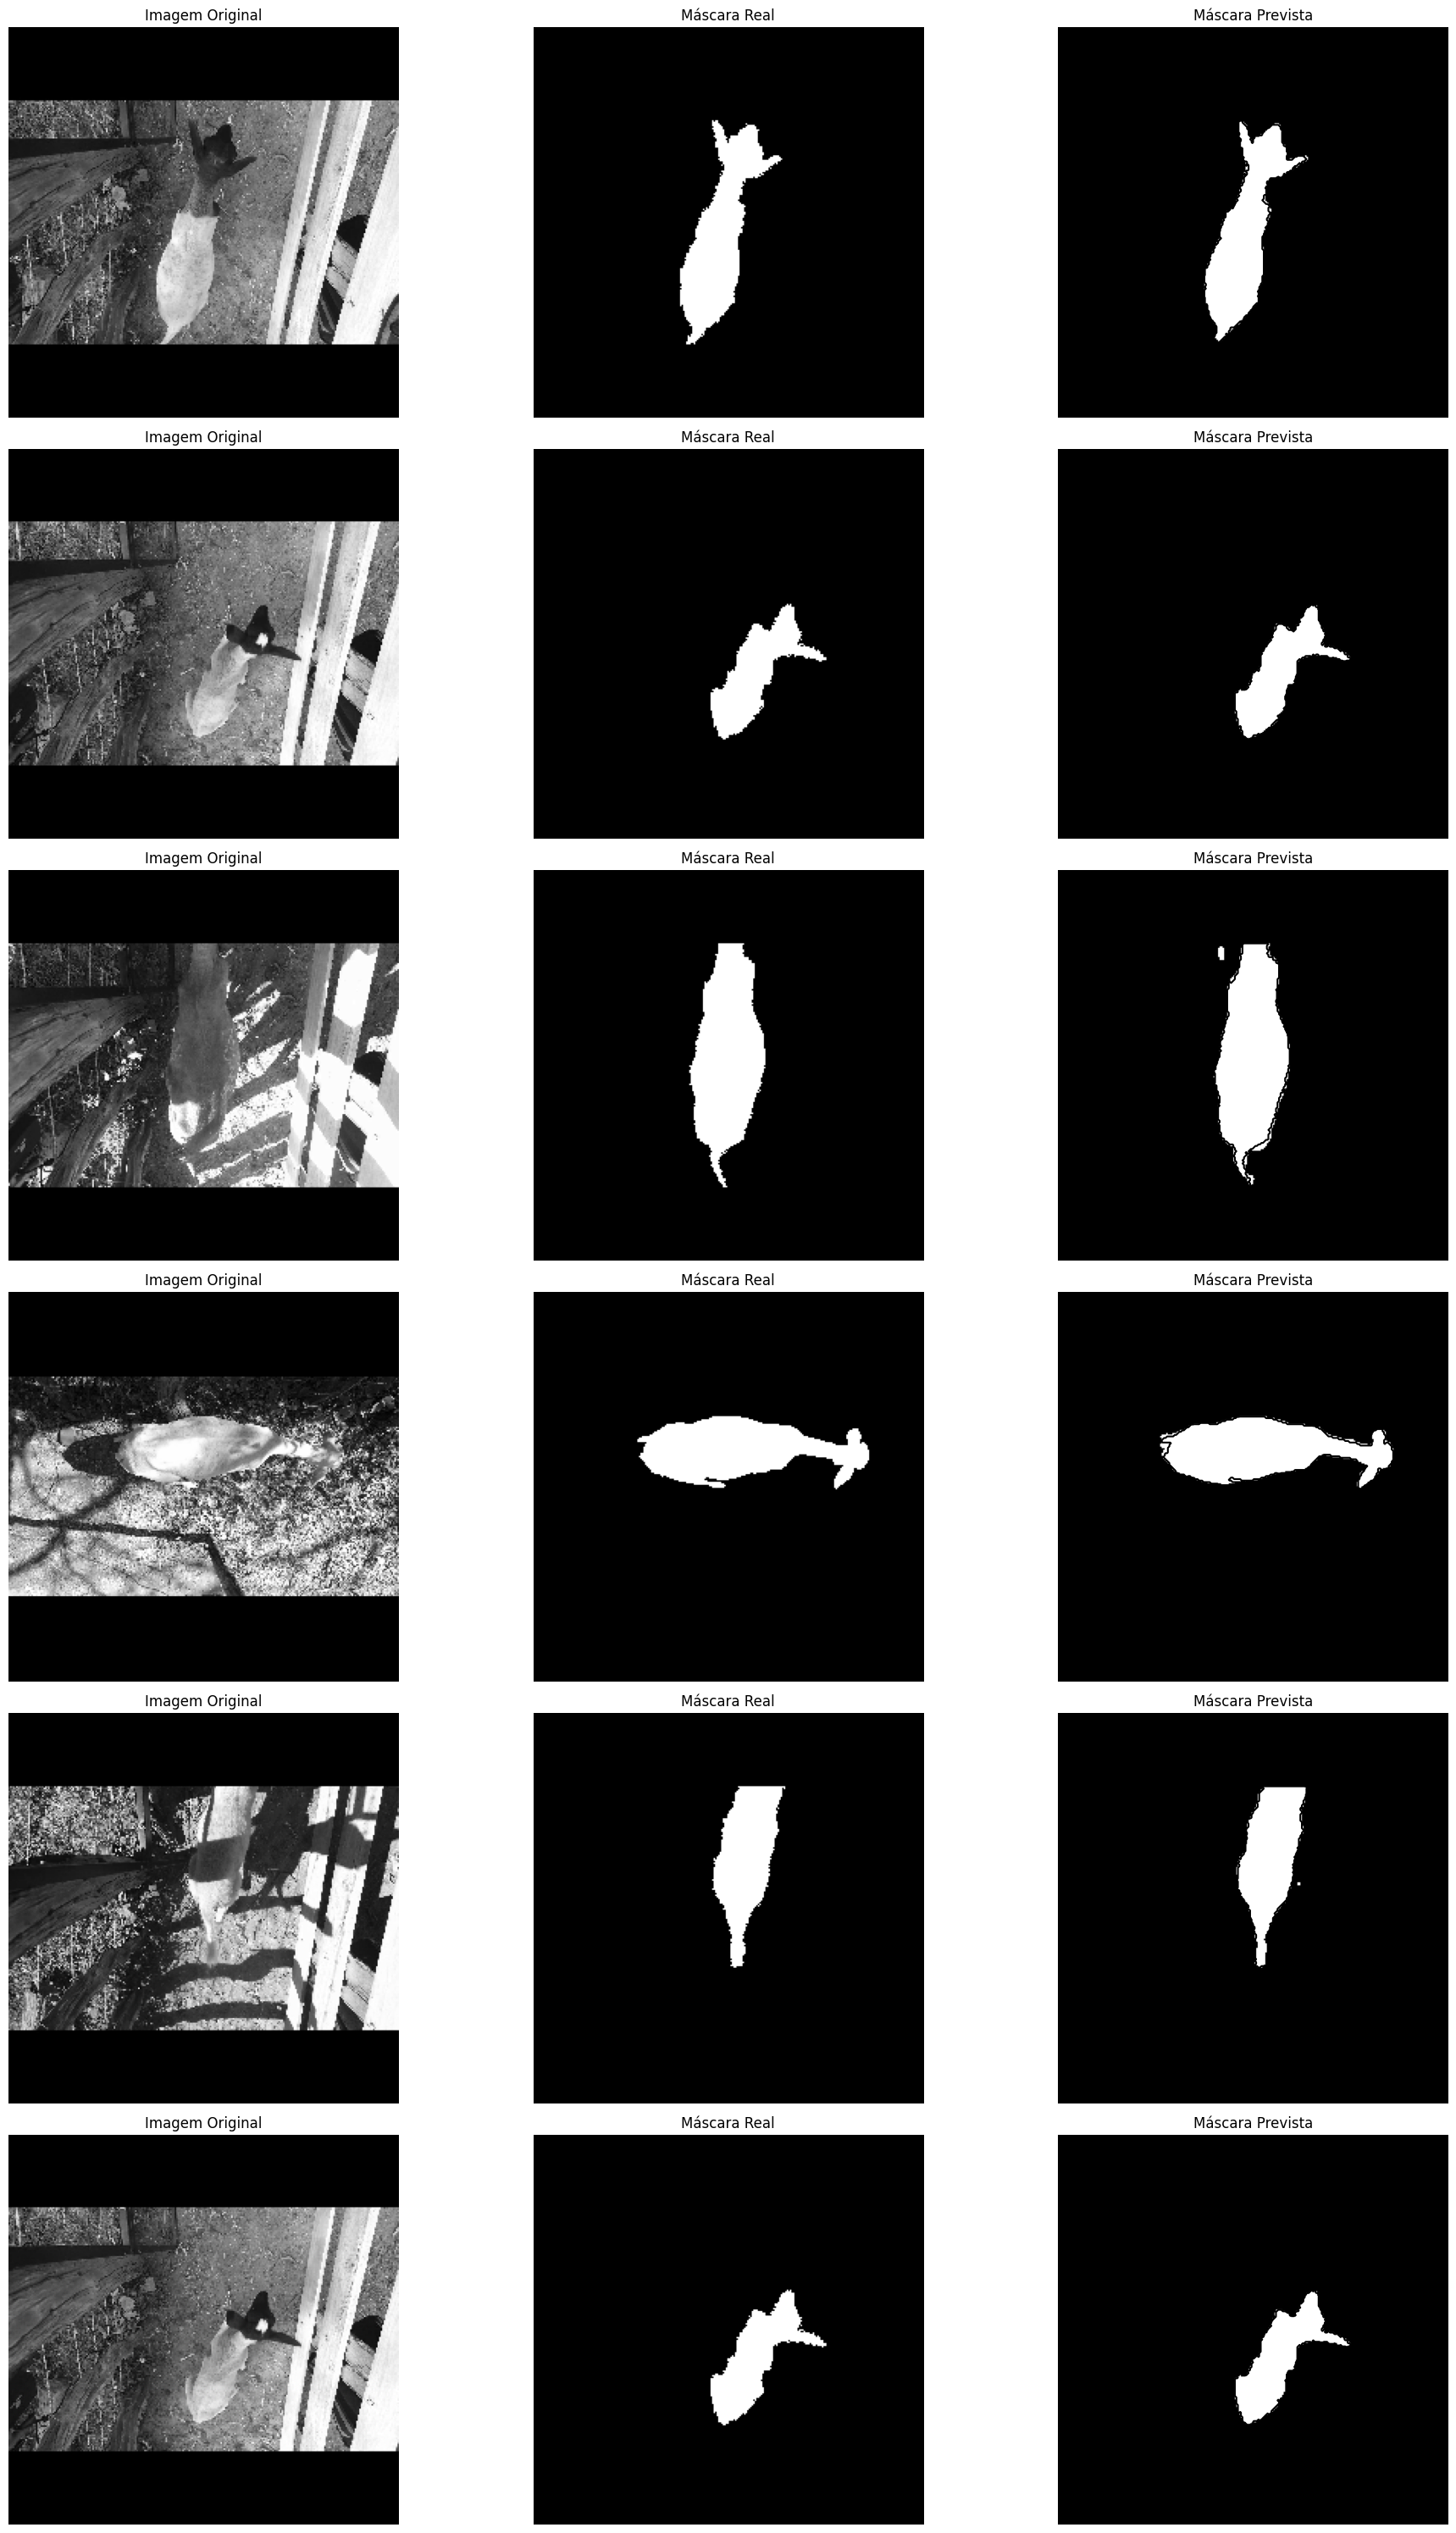

In [14]:
import matplotlib.pyplot as plt
import random

def plot_samples(X, y, preds, num_samples=5):
    """
    Exibe várias amostras aleatórias do conjunto de dados, mostrando:
    - Imagem original
    - Máscara real (Ground Truth)
    - Máscara predita pelo modelo

    Args:
        X (np.array): Imagens originais.
        y (np.array): Máscaras reais.
        preds (np.array): Máscaras preditas pelo modelo.
        num_samples (int): Número de amostras a serem exibidas.
    """
    # Selecionar índices aleatórios
    indices = random.sample(range(len(X)), num_samples)

    # Criar subplots
    fig, axes = plt.subplots(num_samples, 3, figsize=(20, 5 * num_samples))
    
    for i, ix in enumerate(indices):
        # Imagem original
        axes[i, 0].imshow(X[ix, ..., 0], cmap='gray')  # Para imagens em escala de cinza
        axes[i, 0].set_title("Imagem Original")
        axes[i, 0].axis('off')

        # Máscara real
        axes[i, 1].imshow(y[ix].squeeze(), cmap='gray')
        axes[i, 1].set_title("Máscara Real")
        axes[i, 1].axis('off')

        # Máscara predita
        axes[i, 2].imshow(preds[ix].squeeze(), cmap='gray')
        axes[i, 2].contour(y[ix].squeeze(), colors='k', levels=[0.5])  # Contorno da máscara real
        axes[i, 2].set_title("Máscara Prevista")
        axes[i, 2].axis('off')

    # Ajustar espaçamento
    plt.tight_layout()
    plt.show()

# Gerar predições binarizadas
pred_masks = model.predict(test_images, batch_size=6)
pred_masks_bin = (pred_masks > 0.5).astype(np.float32)

# Plotar múltiplas amostras
plot_samples(test_images, test_masks, pred_masks_bin, num_samples=6)

In [15]:
from tensorflow.keras.preprocessing.image import array_to_img
import os
import numpy as np

def save_predicted_masks(model, test_images, filenames, output_dir):
    """
    Realiza a predição para cada imagem do conjunto de teste e salva as máscaras geradas.

    Args:
        model (tf.keras.Model): Modelo carregado com os pesos para predição.
        test_images (np.array): Conjunto de imagens carregadas para predição.
        filenames (list): Lista de nomes originais das imagens.
        output_dir (str): Diretório onde as máscaras geradas serão salvas.
    """
    # Garantir que o diretório de saída exista
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    print("Iniciando a predição e salvamento das máscaras...")
    for i, (img, filename) in enumerate(zip(test_images, filenames)):
        try:
            # Adicionar dimensão de batch à imagem para predição
            img_input = np.expand_dims(img, axis=0)

            # Realizar a predição
            pred_mask = model.predict(img_input, batch_size=1)

            # Binarizar a máscara predita
            pred_mask_bin = (pred_mask.squeeze() > 0.5).astype(np.float32)

            # Converter a máscara binarizada para formato de imagem
            mask_img = array_to_img(pred_mask_bin[..., np.newaxis])  # Adicionar canal para salvar corretamente

            # Salvar a máscara no diretório de saída
            save_path = os.path.join(output_dir, filename)
            mask_img.save(save_path)

            print(f"Máscara {i+1}/{len(test_images)} salva: {save_path}")
        except Exception as e:
            print(f"Erro ao processar {filename}: {e}")

    print(f"Todas as máscaras foram salvas em {output_dir}")

# Diretório para salvar as máscaras
output_dir = 'teste/mascaras_preditas_pre'

# Nomes dos arquivos de teste
filenames = sorted(os.listdir('teste/images_pad'))

# Executar a função para salvar as máscaras
save_predicted_masks(model, test_images, filenames, output_dir)

Iniciando a predição e salvamento das máscaras...
1/1 [==============================] - 0s 46ms/step
Máscara 1/542 salva: teste/mascaras_preditas_pre\C1_03 (1).png
1/1 [==============================] - 0s 46ms/step
Máscara 2/542 salva: teste/mascaras_preditas_pre\C1_03 (10).png
1/1 [==============================] - 0s 48ms/step
Máscara 3/542 salva: teste/mascaras_preditas_pre\C1_03 (2).png
1/1 [==============================] - 0s 47ms/step
Máscara 4/542 salva: teste/mascaras_preditas_pre\C1_03 (3).png
1/1 [==============================] - 0s 48ms/step
Máscara 5/542 salva: teste/mascaras_preditas_pre\C1_03 (4).png
1/1 [==============================] - 0s 47ms/step
Máscara 6/542 salva: teste/mascaras_preditas_pre\C1_03 (5).png
1/1 [==============================] - 0s 44ms/step
Máscara 7/542 salva: teste/mascaras_preditas_pre\C1_03 (6).png
1/1 [==============================] - 0s 47ms/step
Máscara 8/542 salva: teste/mascaras_preditas_pre\C1_03 (7).png
1/1 [========================